In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os

# # NumPyの出力設定を変更
# np.set_printoptions(threshold=np.inf)

# # Pandasの出力設定を変更
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# カレントディレクトリを取得
current_dir = os.getcwd()

# ファイルの相対パスを設定
data_file_path = os.path.join(current_dir, 'FrcSub', 'data.txt')
q_matrix_file_path = os.path.join(current_dir, 'FrcSub', 'q.txt')

# ファイルの存在確認
if not os.path.exists(data_file_path):
    raise FileNotFoundError(f"{data_file_path} not found.")
if not os.path.exists(q_matrix_file_path):
    raise FileNotFoundError(f"{q_matrix_file_path} not found.")

# ファイルの読み込み
response_data = np.loadtxt(data_file_path, dtype=int)
q_matrix = np.loadtxt(q_matrix_file_path, dtype=int)

# DINAモデルの計算関数
# ここにDINAモデルの計算関数を追加
def dina_model_likelihood(attribute_profile, response_data, q_matrix, slip, guess):
    n_students, n_items = response_data.shape
    n_attributes = attribute_profile.shape[1]
    
    mastery = np.dot(attribute_profile, q_matrix.T) == q_matrix.sum(axis=1)
    prob_correct = mastery * (1 - slip) + (1 - mastery) * guess
    likelihood = prob_correct ** response_data * (1 - prob_correct) ** (1 - response_data) #回答と予測の一致を測る
    return np.prod(likelihood, axis=1) #各問題の確率を掛け合わせる

def estimate_parameters(response_data, q_matrix):
    n_students, n_items = response_data.shape
    n_attributes = q_matrix.shape[1]

    # 全ての可能なアトリビュートプロファイルを生成
    attribute_profiles = np.array(np.meshgrid(*[[0, 1]] * n_attributes)).T.reshape(-1, n_attributes)

    # 初期値
    slip = 0.2
    guess = 0.2

    # 最尤推定
    def negative_log_likelihood(params):
        slip, guess = params
        likelihoods = np.zeros((n_students, attribute_profiles.shape[0]))
        # それぞれのアトリビュートプロファイルに対して尤度を計算
        for i, profile in enumerate(attribute_profiles):
            likelihoods[:, i] = dina_model_likelihood(profile.reshape(1, -1), response_data, q_matrix, slip, guess)
        # slipとguessの最適化のため
        student_likelihoods = np.sum(likelihoods, axis=1)
        return -np.sum(np.log(student_likelihoods))

    result = minimize(negative_log_likelihood, [slip, guess], bounds=[(0, 1), (0, 1)])
    slip, guess = result.x

    if result.success:
        slip, guess = result.x
        print(f"最適化成功！\nスリップ確率: {slip}\n推測確率: {guess}")
    else:
        print(f"最適化失敗！\n理由: {result.message}")

    # 学生ごとの習得アトリビュートを推定
    estimated_attributes = []
    # それぞれの学生に対して最も尤度が高いアトリビュートプロファイルを選択
    for responses in response_data:
        likelihoods = [dina_model_likelihood(profile.reshape(1, -1), responses.reshape(1, -1), q_matrix, slip, guess) 
                       for profile in attribute_profiles]
        estimated_attributes.append(attribute_profiles[np.argmax(likelihoods)])

    return np.array(estimated_attributes), slip, guess

# モデル推定
estimated_attributes, slip, guess = estimate_parameters(response_data, q_matrix)

# 結果を表示
print("response_data:", response_data)
print("推定された習得アトリビュート:")
print(estimated_attributes)
print(f"推定されたスリップ確率: {slip}")
print(f"推定された推測確率: {guess}")


/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_72817/982212318.py:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(student_likelihoods))


最適化成功！
スリップ確率: 0.2
推測確率: 0.2
response_data: [[0 0 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 0 0 0]]
推定された習得アトリビュート:
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 0 1 1]
 [1 1 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 1 1 1]
 [0 1 0 ... 1 1 1]]
推定されたスリップ確率: 0.2
推定された推測確率: 0.2


In [2]:
from collections import Counter
import pandas as pd

# アトリビュートプロファイルごとの人数を計算
attribute_counts = Counter([tuple(attr) for attr in estimated_attributes])

# 結果をデータフレームに変換して見やすく表示
attribute_counts_df = pd.DataFrame(
    list(attribute_counts.items()), 
    columns=["Attribute Profile", "Count"]
)

# カウント順にソート
attribute_counts_df = attribute_counts_df.sort_values(by="Count", ascending=False)

# 結果を表示
print(attribute_counts_df)

           Attribute Profile  Count
12  (1, 1, 1, 1, 1, 1, 1, 1)    120
7   (0, 0, 0, 0, 0, 0, 0, 0)     60
11  (0, 1, 0, 0, 0, 0, 1, 1)     55
6   (0, 1, 0, 0, 0, 0, 0, 0)     38
1   (1, 1, 1, 1, 1, 0, 1, 1)     33
14  (0, 1, 0, 1, 0, 1, 1, 1)     24
3   (0, 1, 1, 1, 1, 1, 1, 1)     20
4   (0, 0, 0, 0, 0, 0, 1, 1)     17
5   (0, 1, 0, 0, 0, 0, 1, 0)     17
8   (1, 1, 0, 1, 0, 1, 1, 1)     15
9   (0, 1, 0, 1, 1, 1, 1, 1)     15
19  (0, 1, 0, 1, 0, 1, 1, 0)     10
37  (0, 1, 0, 1, 0, 0, 1, 1)      8
24  (0, 0, 0, 1, 0, 1, 1, 1)      8
17  (1, 1, 0, 1, 0, 1, 1, 0)      7
0   (1, 1, 1, 0, 1, 1, 1, 1)      7
10  (0, 0, 0, 0, 0, 0, 1, 0)      7
28  (0, 0, 0, 1, 0, 1, 1, 0)      6
15  (1, 1, 1, 0, 1, 1, 1, 0)      5
13  (0, 1, 0, 0, 1, 1, 1, 0)      5
21  (1, 1, 0, 1, 1, 1, 1, 1)      5
34  (0, 1, 1, 1, 1, 0, 1, 1)      4
23  (1, 1, 1, 1, 1, 1, 1, 0)      4
40  (0, 1, 0, 1, 1, 1, 1, 0)      4
25  (1, 0, 0, 1, 0, 1, 1, 1)      4
32  (0, 1, 0, 1, 1, 0, 1, 1)      4
29  (1, 1, 0, 0, 0, 0, 1, 1)

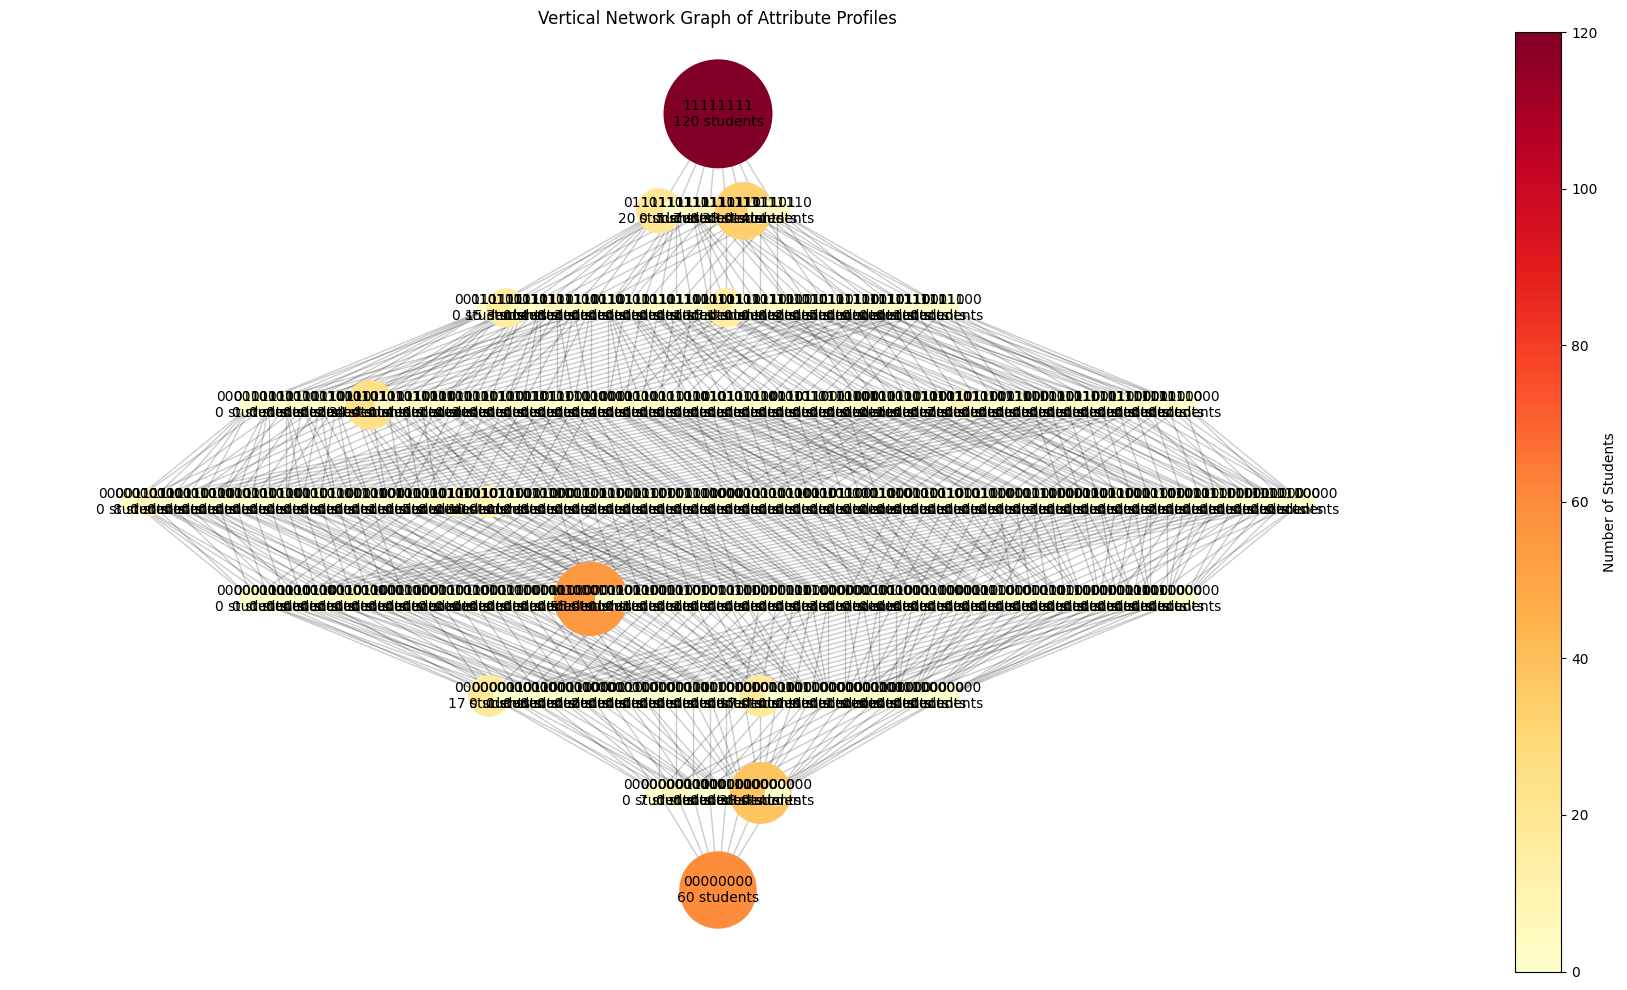

In [3]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# アトリビュート数を取得
num_attributes = estimated_attributes.shape[1]

# すべての可能な状態（アトリビュートプロファイル）を生成
states = list(itertools.product([0, 1], repeat=num_attributes))

# 各状態の学生数をカウント
state_counts = defaultdict(int)
for attr in estimated_attributes:
    state_counts[tuple(attr)] += 1

# グラフ作成
G = nx.Graph()

# ノードを追加し、学生数を属性として設定
for state in states:
    G.add_node(state, count=state_counts[state])

# エッジを追加
for state in states:
    for i in range(num_attributes):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                G.add_edge(state, next_state)

# カスタムレイアウト
def custom_layout(G, num_attributes):
    pos = {}
    levels = {}
    for state in G.nodes():
        level = sum(state)  # 状態の1の数でレベルを定義
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # レベルごとにノードを配置
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            x = i - (num_nodes_at_level - 1) / 2
            y = level
            pos[state] = (x, y)
    return pos

# レイアウトを適用
pos = custom_layout(G, num_attributes)

# x座標を正規化
x_values = [pos[node][0] for node in pos]
min_x, max_x = min(x_values), max(x_values)
for node in pos:
    x, y = pos[node]
    x_norm = (x - min_x) / (max_x - min_x)
    pos[node] = (x_norm, y)

# グラフ設定
plt.figure(figsize=(18, 10))
nx.draw_networkx_edges(G, pos, alpha=0.2)

# ノードのサイズと色を学生数に基づいて調整
node_sizes = [max(300, state_counts[node] * 50) for node in G.nodes()]
node_colors = [state_counts[node] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd
)

# ラベルを追加
labels = {node: f"{''.join(map(str, node))}\n{state_counts[node]} students" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10)

# カラーバーの追加
plt.colorbar(nodes, label='Number of Students')

# グラフの仕上げ
plt.title('Vertical Network Graph of Attribute Profiles')
plt.axis('off')
plt.tight_layout()
plt.show()


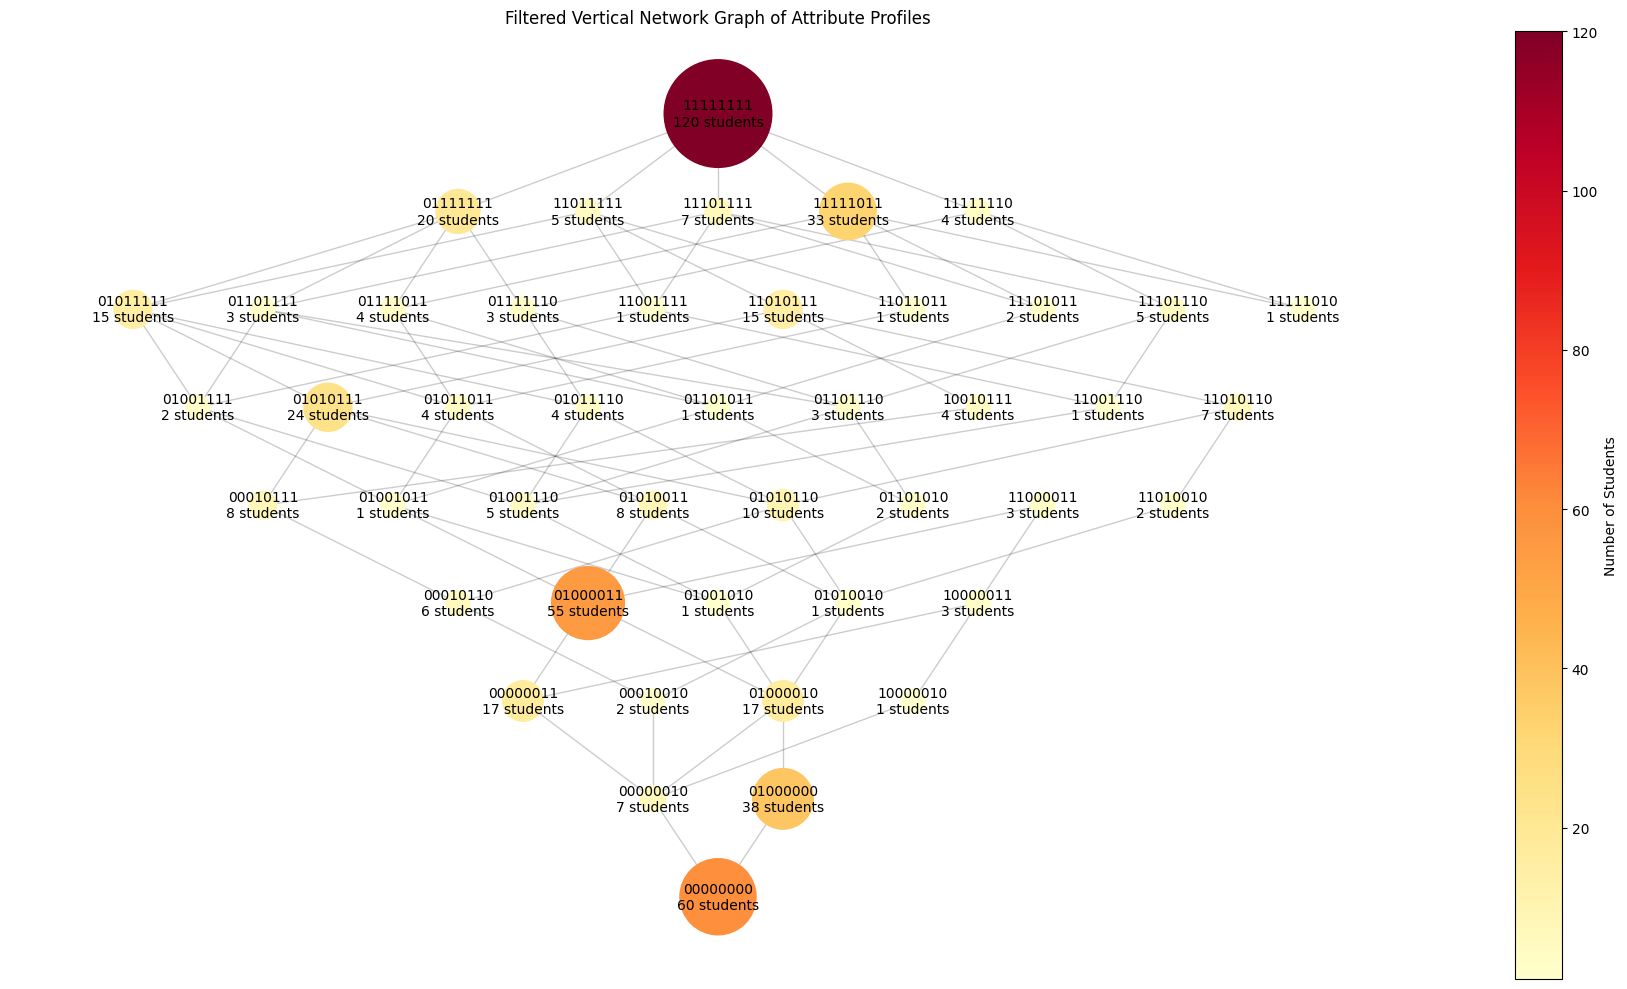

In [4]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# アトリビュート数を取得
num_attributes = estimated_attributes.shape[1]

# すべての可能な状態（アトリビュートプロファイル）を生成
states = list(itertools.product([0, 1], repeat=num_attributes))

# 各状態の学生数をカウント
state_counts = defaultdict(int)
for attr in estimated_attributes:
    state_counts[tuple(attr)] += 1

# 学生数がゼロの状態を除外
filtered_states = [state for state in states if state_counts[state] > 0]

# グラフ作成
G_filtered = nx.Graph()

# ノードを追加し、学生数を属性として設定
for state in filtered_states:
    G_filtered.add_node(state, count=state_counts[state])

# エッジを追加
for state in filtered_states:
    for i in range(num_attributes):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in filtered_states:
                G_filtered.add_edge(state, next_state)

# カスタムレイアウト
def custom_layout(G, num_attributes):
    pos = {}
    levels = {}
    for state in G.nodes():
        level = sum(state)  # 状態の1の数でレベルを定義
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # レベルごとにノードを配置
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            x = i - (num_nodes_at_level - 1) / 2
            y = level
            pos[state] = (x, y)
    return pos

# レイアウトを適用
pos_filtered = custom_layout(G_filtered, num_attributes)

# グラフ設定
plt.figure(figsize=(18, 10))
nx.draw_networkx_edges(G_filtered, pos_filtered, alpha=0.2)

# ノードのサイズと色を学生数に基づいて調整
node_sizes_filtered = [max(300, state_counts[node] * 50) for node in G_filtered.nodes()]
node_colors_filtered = [state_counts[node] for node in G_filtered.nodes()]
nodes_filtered = nx.draw_networkx_nodes(
    G_filtered, pos_filtered, node_size=node_sizes_filtered, node_color=node_colors_filtered, cmap=plt.cm.YlOrRd
)

# ラベルを追加
labels_filtered = {node: f"{''.join(map(str, node))}\n{state_counts[node]} students" for node in G_filtered.nodes()}
nx.draw_networkx_labels(G_filtered, pos_filtered, labels_filtered, font_size=10)

# カラーバーの追加
plt.colorbar(nodes_filtered, label='Number of Students')

# グラフの仕上げ
plt.title('Filtered Vertical Network Graph of Attribute Profiles')
plt.axis('off')
plt.tight_layout()
plt.show()
